In [ ]:
# based on
# https://github.com/google-research/google-research/blob/master/neural_additive_models/models.py

# with some help from
# https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
def exu(x, weight, bias):
    """ExU hidden unit modification."""
    return tf.exp(weight) * (x - bias)


# Activation Functions
def relu(x, weight, bias):
    """ReLU activation."""
    return tf.nn.relu(weight * (x - bias))


def relu_n(x, n=1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)

In [4]:
class ActivationLayer(tf.keras.layers.Layer):
    """Custom activation Layer to support ExU hidden units."""

    def __init__(self,
               num_units,
               name = None,
               activation = 'exu',
               trainable = True):
        """Initializes ActivationLayer hyperparameters.
        Args:
          num_units: Number of hidden units in the layer.
          name: The name of the layer.
          activation: Activation to use. The default value of `None` corresponds to
            using the ReLU-1 activation with ExU units while `relu` would use
            standard hidden units with ReLU activation.
          trainable: Whether the layer parameters are trainable or not.
        """
        super(ActivationLayer, self).__init__(trainable=trainable, name=name)
        self.num_units = num_units
        self._trainable = trainable
        if activation == 'relu':
            self._activation = relu
            self._beta_initializer = 'glorot_uniform'
        elif activation == 'exu':
            self._activation = lambda x, weight, bias: relu_n(exu(x, weight, bias))
            #       self._beta_initializer = tf.initializers.truncated_normal(
            #           mean=4.0, stddev=0.5)\
            self._beta_initializer = tf.initializers.TruncatedNormal(
            mean=4.0, stddev=0.5)
        else:
            raise ValueError('{} is not a valid activation'.format(activation))

    def build(self, input_shape):
        """Builds the layer weight and bias parameters."""
        self._beta = self.add_weight(
            name='beta',
            shape=[input_shape[-1], self.num_units],
            initializer=self._beta_initializer,
            trainable=self._trainable)
        self._c = self.add_weight(
            name='c',
            shape=[1, self.num_units],
        #         initializer=tf.initializers.truncated_normal(stddev=0.5),
            initializer=tf.initializers.TruncatedNormal(stddev=0.5),
            trainable=self._trainable)
        super(ActivationLayer, self).build(input_shape)

    @tf.function
    def call(self, x):
        """Computes the output activations."""
        center = tf.tile(self._c, [tf.shape(x)[0], 1])
        out = self._activation(x, self._beta, center)
        return out

In [5]:
layer = ActivationLayer(10)

In [6]:
layer

In [7]:
layer.built

False

In [8]:
_ = layer(tf.zeros(10))

In [9]:
layer.built

True

In [10]:
print([var.name for var in layer.trainable_variables])


['activation_layer/beta:0', 'activation_layer/c:0']


In [11]:
layer._beta

<tf.Variable 'activation_layer/beta:0' shape=(10, 10) dtype=float32, numpy=
array([[3.0006227, 4.272725 , 3.8499842, 3.5448945, 4.253598 , 3.477216 ,
        3.91356  , 3.874106 , 4.1269617, 4.268689 ],
       [3.7775166, 4.6190233, 4.5522094, 4.1272254, 4.0850677, 4.2082767,
        4.4080524, 3.888571 , 3.913987 , 3.7514622],
       [3.455721 , 4.421679 , 3.0027995, 3.7838764, 4.7486353, 4.2654624,
        4.402561 , 3.8927302, 3.9466476, 4.2914715],
       [3.473099 , 4.2423053, 4.062012 , 4.13985  , 3.7153313, 3.8983886,
        4.437923 , 4.526012 , 3.804579 , 4.3974667],
       [3.5074332, 3.8827374, 3.3819926, 3.60641  , 4.70245  , 3.953009 ,
        4.4866047, 3.3015141, 4.4266853, 4.2532015],
       [3.523488 , 4.4288564, 4.1830697, 3.939189 , 3.982775 , 3.6061513,
        4.163121 , 4.4758863, 4.491218 , 4.125172 ],
       [3.4592934, 3.9580853, 4.000693 , 3.9927166, 3.2357574, 4.5590935,
        3.6400366, 4.361662 , 3.8635812, 3.9999967],
       [3.8056824, 4.3147483, 4.819

In [12]:
layer._c

<tf.Variable 'activation_layer/c:0' shape=(1, 10) dtype=float32, numpy=
array([[ 0.724453  ,  0.17950083,  0.9090162 , -0.13001223, -0.43867257,
         0.12684421,  0.03929547,  0.7450514 , -0.18756944,  0.62589616]],
      dtype=float32)>

In [44]:
input_dim = 1
output_dim = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(input_dim,)))
model.add(ActivationLayer(500))
# model.add(ActivationLayer(200))
model.add(tf.keras.layers.Dense(output_dim, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_layer_4 (Activati (None, 500)               1000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [45]:
def gen_test_data():
    # x = np.linspace(-np.pi/2., np.pi/2., 100)
    # y = np.cos(10*x) + np.sin(5*x)
    x = np.linspace(0, 1, 200)
    y = np.cos(50*x) + np.sin(5*x)
    return x, y

In [46]:
x, y = gen_test_data()

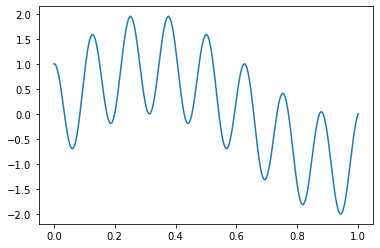

In [47]:
plt.figure()
plt.plot(x, y)

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)

In [49]:
%%time
history = model.fit(x, y, epochs=1000, batch_size=x.shape[0])

Epoch 1/1000
1/1 [==============================] - 0s 837us/step - loss: 1.3629
Epoch 2/1000
1/1 [==============================] - 0s 649us/step - loss: 0.9383
Epoch 3/1000
1/1 [==============================] - 0s 672us/step - loss: 0.8251
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8713
Epoch 5/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.9007
Epoch 6/1000
1/1 [==============================] - 0s 743us/step - loss: 0.8486
Epoch 7/1000
1/1 [==============================] - 0s 822us/step - loss: 0.7498
Epoch 8/1000
1/1 [==============================] - 0s 921us/step - loss: 0.6573
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6041
Epoch 10/1000
1/1 [==============================] - 0s 759us/step - loss: 0.5924
Epoch 11/1000
1/1 [==============================] - 0s 815us/step - loss: 0.5985
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5942
Epoch 13/1000
1/1 [===========

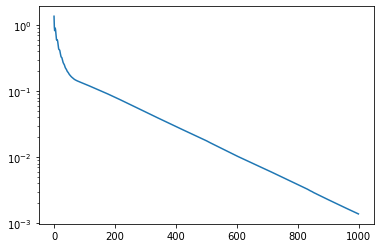

In [50]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

In [51]:
x.shape

(200,)

In [52]:
yhat = model.predict(x)

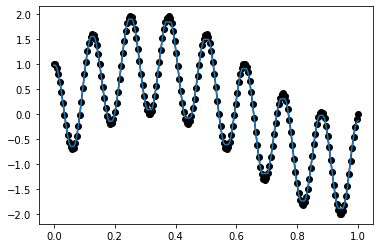

In [53]:
plt.figure()
plt.plot(x, y, 'k-o')
plt.plot(x, yhat)